# Privacy in Datascience

## Name - Prashant Nandakumar | AndrewID - pnandak1

## Introduction
In light of the recent Cambridge Analytica leaks, it has become apparent that protecting user privacy should be considered with utmost importance, especially when that data is used as the source for analytics and extracting other insights. Some even argue that applications like Facebook have no business storing user actions (likes, reactions etc.), let alone sell them to advertisers.While data privacy has been clubbed with security (both being applications of crypto), it has not been until the 2000s that formal approaches to studying privacy have emerged. While naïve attempts at anonymizing user information like masking user ID or username fall prey to linkage attacks (essentially cross referencing the
data with other available data sources), new techniques like k-anonymity, differential privacy aim at modifying the published data either by collating features in the former or by adding perturbations in the latter. In recent years, differential privacy has emerged as a popular choice since it has privacy built into its definition and practical implementations of the same have been considered to have “Good enough” privacy. Of course this comes at a cost as modifying data by adding noise would also affect the utility/accuracy of the same. In this project, I analyse the utility/privacy tradeoffs in some Differential Privacy(DP) techniques.

## Differential Privacy
Consider the below setting. <br>
<img src="http://drive.google.com/uc?export=view&id=1IRd7dmxUr6SvVrhJ3RX0c_O5l8ZwRhbF"><br>
Participants contribute information to a database. The database curator either publishes the data directly or exposes a query interface to the data. Interested parties then query the database to obtain relevant information. In this setting, what is the guarantee that a user's individual contribution is completely protected. If the database were to have sensitive information like health data, PII, or (how many Justin Bieber albums does one own?), what guarantees would a person expect so that his/her contribution is not compromised in a privacy breach? <br>

Differential privacy builds on the premise that a person might feel comfortable contributing data if it can be guaranteed that nothing new would be learnt about them from participating in the database, than what would've been possible otherwise.

Given an algorithm A that outputs value λ when run on a dataset V, the goal of differential privacy is to ‘hide’ the effect of a small change in V on the output of A. Equivalently, an attacker should not be able to tell if a private record was swapped in V just by looking at the output of A. If two datasets V and V' differ by swapping a single element, we will refer to them as neighboring datasets. Note that any non-trivial algorithm (i.e., an algorithm A that outputs different values on V and V') must incorporate some randomness for a change in V to be unobservable in the output. <br>
This brings us to the formal definition of Differential Privacy -<br>

$$Pr[A(V) = \lambda ] = e^{\varepsilon }Pr[A(V') = \lambda ] $$

For two neighbouring datasets V and V' that differs by one entry, a mechanism A is considered to be differentially private if it satisfies the equation above.  <br>
The above definition is called "$\varepsilon$ - differential privacy", where  $\varepsilon$ is a tunable parameter. It is quite apparent that lower the value of $\varepsilon$, higher the privacy since $Pr[A(V) = \lambda ]$ and $Pr[A(V') = \lambda ]$ would start to appear more and more similar. Privacy is maximum when  $\varepsilon$ is 0.


## Laplace Mechanism
The global sensitivity of an algorithm A over all neighboring datasets V, V' where V and V' differ by one record is given by-<br>

$$\Delta_{A} = max_{V,V'\subseteq X} \left \| A(V) - A(V') \right \|_{1}$$

That is the worst case difference between A(V) and A(V') for all possible V and V' combinations.

Given a dataset $V$ and an algorithm $A$, the Laplace mechanism returns A(V) + ω, where ω is a noise variable drawn from $Lap(\Delta _{A}/\varepsilon )$, the Laplace distribution with scale parameter $\Delta _{A}/\varepsilon$ (and location parameter 0). Dworak et al. have shown that this mechanism is differentially private. For a formal proof, please refer to their work


As an example. lets treat the counting operation on the star(*) ratings of restaurants in Yelp as a private operation, the laplace mechanism can be applied as follows.

### Data Collection from Yelp

Since Yelp lets you collect only 1000 business entries per search query, we shall break down the search query of a city using the bearing angle. <br>
The old API allowed one to perform a grid search. But that has now been removed. The new API allows one to search using latitude, longitude + radius. We shall use the bearing angle and the co-ordinate search to get a full listing of businesses in a city
The bearing angle is a term borrowed from navigation, which essentially indicates the angle between the geographic north and the desired direction in a clockwise direction. The figure below illustrates bearing angles of 65 and 300 degrees.
<img src="http://drive.google.com/uc?export=view&id=145G8g-olylKOJtsvQXUosZoek11IkOHd">

Using a center latitude, longitude co-ordinate, distance and bearing angle, one can get the latitude, longitude co-ordinates of the new location.<br>
Thus we will break down our search of a region into 5 sub-searches using bearing angles of [45,135,225,315] like so-
<img src="http://drive.google.com/uc?export=view&id=1wDlsaQMVCquUC2wMg8sxx5UHrp8RLsI5">
We shall then remove all the overlapping businesses

In [ ]:
import geopy
from geopy.distance import VincentyDistance
import io, time, json
import requests

def get_coord(api_key, lat, lon, s, d):
    response = requests.get('https://api.yelp.com/v3/businesses/search', headers = {'Authorization': 'Bearer {}'.format(api_key)}, 
                            params= {'latitude':lat, 'longitude':lon, 'radius':d } )
    print(response)
    data = response.json()
    total = data['total']
    print(total)
    if total > 1000:
        #print('Alarm...query returned more than 1000 entries...recurse!')
        total = 1000
    names = []
    for each in data['businesses']:
        j = each#json.loads(each)
        if j['id'] not in s:
            names.append(each)
            s.add(j['id'])
    read = len(data['businesses'])
    offset = read
    n_page = read
    while total > read:
        time.sleep(0.2)
        response = requests.get('https://api.yelp.com/v3/businesses/search', headers = {'Authorization': 'Bearer {}'.format(api_key)}, \
                            params= {'latitude':lat, 'longitude':lon, 'radius':d , 'limit': n_page, 'offset': offset} )
        data = response.json()
        read += len(data['businesses'])
        for each in data['businesses']:
            j = each#json.loads(each)
            if j['id'] not in s:
                names.append(each)
                s.add(j['id'])    
        offset += n_page
        
    return names

def all_businesses(api_key, lat, lon, area=0):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    res = []
    s = set()
    d = 6000#10*1.6*1000
    res += get_coord(api_key, lat, lon, s, d)
    
    bearing = [45,135,225,315]
    for b in bearing:
        origin = geopy.Point(lat, lon)
        destination = VincentyDistance(kilometers=1.5*d/1000).destination(origin, b)
        lat2, lon2 = destination.latitude, destination.longitude
        res +=  get_coord(api_key, lat2, lon2, s, d)
    return res
# AUTOLAB_IGNORE_START
api_key = read_api_key('api_key.txt')
#Reno = 39.5296, -119.8138
#salt lake = 40.7608, -111.8910
#modesto = 37.6391, -120.9969
names = all_businesses(api_key,38.5816, -121.4944)

def read_api_key(filepath):
    with open('api_key.txt', 'r') as f:
        return f.read().replace('\n','')

api_key = read_api_key('api_key.txt')
#Sacramento = 38.5816, -121.4944, area = 100 sq.miles
names = all_businesses(api_key, 38.5816, -121.494)


In [465]:
ratings = [i['rating'] for i in names] 

The global sensitivity of the ratings information is 5.0. This is because a businesses added/deleted can have a rating of atmost 5. Thus if the count needs to be released privately, you would add the actual result with a laplace obtained with this sensitivity parameter, and say an epsilon of 1
np.random.laplace(scale=500,size=1)

In [483]:
epsilon = 1
sensitivity = 5
scale = sensitivity/epsilon
print('privately released rating sum ', sum(ratings) + np.random.laplace(scale=scale,size=1))

privately released rating sum  [7821.74452567]


In [482]:
print('actual rating sum ', sum(ratings))

actual rating sum  7818.0


While laplace mechanism works well for a single dimensional query, more involved schemes are necessary for multi-dimensional queries.

## Note:
At this point it should be noted that Differential Privacy essentially involves adding noise to a query, in order to provide the necessary privacy guarantees. THe kind of noise added depends on the query mechanism, the quantity being queried, the number of queries to be made etc.<br>
One is referred to Cynthia Dworak's seminal work for a complete treatment of the same.
There is no one size fits all approach to DP ie. there is no black box solution to making a mechanism differentially private. THe approach instead depends on the underlying operation being performed. You have different approaches for classification, machine learning, bayesian optimization etc. 


## Mechanisms:
THere are several mechanisms for achieving differential privacy:
* <b>Input perturbation:</b>
Noise is added to the input. Schemes like these would be of most use on personal devices. eg: Apple uses differential privacy on handsets to capture keyboard usage data.

* <b>Output perturbation:</b>
Noise is added to the output of a query. Similar to what we just saw with the laplace mechanism. However, as we shall see the nature of noise depends very much on the kind of operation taking place.

* <b>Objective Mechanism:</b>
Instead of adding noise to the input or the output of an operation, noise is added to the objective function while optimization.

* <b>Exponential Mechanism:</b>
This draws a random output O', such that O' is the closest to the real output O.

<img src="http://drive.google.com/uc?export=view&id=1Fm5GgS8nnYekSB-GAWHaRHMyZBxGQ-p4">



In the following sections, we shall study the output perturbation and objective perturbation of logistic regression models as discussed by Chaudhuri et al. <br>
Note that all the algorithms in the following sections and their proofs for achieving differential privacy can be found in the paper - <br>
<b>"Differentially Private Empirical Risk Minimization"</b> - Kamalika Chaudhuri, Claire Monteleoni and Anand D. Sarwate.

In [399]:
from numpy import *
from pylab import norm
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Comparison of Output and Objective Perturbation in Logistic Regression
For the following sections, we will be using the "Adults" census dataset from the UCI Machine learning repository. The initial plan was to use the Yelp or Netflix dataset, but owing to time and resource(This being a single person project), I decided to use the UCI dataset instead. <br>
We shall be studying a binary classification problem, where the goal is to identify whether the individuals make more than 50K or less than 50K. <br>
The labels used are {+1, -1} and as a result, the loss function is given by -
$$J = log(1+e^{-z}) where z = y*x.\Theta $$


### Model Privacy
These mechanisms provide what is known as model privacy. Given a trained model, one should not be able to infer anything about the data that it was trained on. While this might seem a bit far-fetched. It should be noted that machine learning models have grown in complexity over the years, and the inner workings of some of the deep-learning models is not fully understood. It was shown by Fredrikson et al. that it is possible to obtain a training image from a facial recognition system, only given the target classification. The mechanisms discussed(specifically objective perturbation) can be applied to any optimization method involving stochastic gradient descent.
<img src="http://drive.google.com/uc?export=view&id=1PqD5JvWmbs2AVUNU0MlODtbfcGWtp_zJ">

### Data Preprocessing
* Load the dataset, replace the income field with {+1, -1 } labels.
* Convert categorical columns to binary fields. 
* Normalize columns such that maximum value is 1.
* Normalize rows such that the norm is at most 1. Note that this normalization step is absolutely crucial, as the algorithm is proven to be differentially private only if this condition holds.

In [484]:
def load_data(file_name):
    """ loads and processes data in the manner specified above
    Inputs:
        file_name (str): path to csv file containing data
    Outputs:
        pd.DataFrame: processed dataframe
    """
    df = pd.read_csv(file_name)
    for i in df:
        if not np.issubdtype(df[i].dtype, np.number):
            df.drop(df[df[i] == '?'].index, inplace=True)
            
    df['label'] = np.where(df['income']=='<=50K', -1, 1)
    df.drop(['income'], axis=1, inplace=True)
    return df.reset_index(drop=True)

# AUTOLAB_IGNORE_START
df = load_data('adults.csv')


In [485]:
df1 = pd.get_dummies(df)

labels = np.array(df1['label'], dtype = 'int32')
df2 = df1.drop(['label'], axis=1)
x = df2.as_matrix()

x_max = np.max(x, axis = 0)
y = x/x_max
denom = np.linalg.norm(y, axis = 1)[:, None]
print(denom.shape)
x = y/denom

(30162, 1)


### Train and Test datasets
Split the original dataset into train and test datasets. Also create datasets of multiple sizes. We shall also study the accuracy/privacy tradeoffs on datasets of varying sizes.

In [391]:
split = int(len(x)*3/4)
x_train = x[:split]
y_train = labels[:split]
x_test = x[split:]
y_test = labels[split:]

l = len(x_train)//4
lt = len(x_test)//4
x_train_s = x_train[:l]
y_train_s = y_train[:l]
x_test_s = x_test[:lt]
y_test_s = y_test[:lt]

sz = [3000,4000,7000,10000,15000]
datasets = []
for i in sz:
    x_tr = x_train[:i]
    y_tr = y_train[:i]
    x_te = x_test[:i//3]
    y_te = y_test[:i//3]
    datasets.append((x_tr, y_tr, x_te, y_te))


### Output Perturbation

The algorithm for output perturbation is as follows -

<img src="http://drive.google.com/uc?export=view&id=1l_BVSJi9mvbCJJhXxy8XL8LdCDpLMpZd">
<center>(Picture taken from Chaudhuri et al.) </center><br>
The noise to be added is distributed as $v(b)$ = $\frac{1}{\alpha }e^{-\beta\left \| b \right \|}$
It is not straightforward to sample from this distribution. Instead we perform the sampling in two steps. This information is borrowed from pg.71 of- http://cseweb.ucsd.edu/~kamalika/pubs/WIFStutorial.pdf
* Sample the direction of the noise vector from a uniform distribution
* Sample the norm of the vector from a gamma distribution

Here, we use a simple logistic loss function and minimize the same using gradient descent.

In [324]:
def noisevector(scale, Length):
    r1 = np.random.uniform(size = Length) # Get direction from a uniform distribution
    n1 = norm(r1) 
    
    r2 = r1/n1 # Get unit vector
    
    normn = random.gamma(Length, 1/scale, 1)

    res = r2*normn # Multiply with Norm from Gamma distribution
    return res

def lr(z):
    logr = log(1+exp(-z)) # logistic loss for {+1,-1}
    return logr


def lr_output_perturbation_train(data, labels,eps, lamda=0.1 , num_iters=1000):

    L = len(labels)
    l = len(data[0])
    scale = L* lamda * eps/2 
    noise = noisevector(scale, l)

    theta = np.random.random(data.shape[1])

    def obj_func(x):
        
        j = lr(labels*dot(data,x)).sum()
        f = (1/L)*j + (1/2)*lamda*(norm(x)**2)
        return f
    
    for t in range(num_iters):
        #print(obj_func(theta))
        # deduct gradient = -x.y/(1+exp(x.y.theta))...learning rate = 1
        num = -labels[:,None]*data
        denom = (1+np.exp((labels*dot(data,theta))))
        grad = num/denom[:,None]
        theta -= 1*grad.mean(axis=0)
    
    fpriv = theta + noise


    return fpriv, theta


Obtain the classifier for various settings of $\varepsilon$ along with the baseline(no privacy) and calculate error rate for each of them.

In [426]:
model_p, model_np = lr_output_perturbation_train(x_train_s, y_train_s, 0.05)

In [335]:
def error_rate_compute(data, labels, classifier):
    e = 0
    n = len(labels)
    for i in range(n):
        sign = labels[i]*dot(classifier,data[i])
        if sign<0:
            e = e + 1
    res = e/n
    return res

In [432]:
baseline_err = error_rate_compute(x_test_s, y_test_s,model_np )

In [448]:
eps = [0.05, 0.1, 0.15, 0.2, 0.3,0.4,0.5]
lr_op = []
for i in eps:
    L = len(y_train_s)
    l = len(x_train_s[0])
    scale = L*0.1*i/2
    noise = noisevector(scale, l)
    fpriv = model_np + noise
    lr_op.append(error_rate_compute(x_test_s, y_test_s,fpriv ))

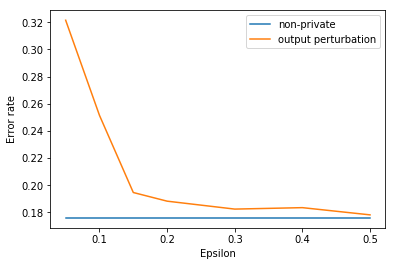

In [449]:
plt.plot(eps, [baseline_err]*len(eps), label='non-private')
plt.plot(eps, lr_op, label='output perturbation')
plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.legend()
plt.show()

Note that accuracy increases, with increase in epsilon. This is because, privacy decreases when epsilon increases.

## Logistic regression with Objective perturbation 
The algorithm for logistic regression with objective perturbation is as follows -
<img src="http://drive.google.com/uc?export=view&id=1PVX8OSe3YhteAEwZw7Y3MXNb1H-TJ77w">
<center>(Picture taken from Chaudhuri et al.) </center><br>

Here, the noise is added to the objective(and hence the gradient) during optimization. The noise vector is sampled similar to what was shown for output perturbation. 

In [375]:
def lr_objective_train(data, labels, epsilon, lamda=1e-4):
    c = 1/4
    L = len(labels)#number of data points in the data set
    l = len(data[0])#length of a data point
    
    param = c/(lamda*L)
    epsilonp = epsilon-2*log(1+ 2*param + param**2)
    
    if epsilonp>0:
        delta = 0
    else:
        delta = c/(L*(exp(epsilon/4)-1))-lamda
        epsilonp = epsilon/2
        
    scale = epsilonp/2 
    noise = noisevector(scale, l)
    
    theta = np.random.random(data.shape[1])

    def obj_func(x):
        jfd = lr(labels*dot(data,x)).sum()
        f = (1/L)*jfd + (1/2)*lamda*(norm(x)**2) + (1/L)*dot(noise,x) + (1/2)*Delta*(norm(x)**2)
        return f
    
    for t in range(1000):
        num = -labels[:,None]*data
        denom = (1+np.exp((labels*dot(data,theta))))
        grad = num/denom[:,None]
        noise = noisevector(scale, l)
        grad = grad.mean(axis=0) + lamda*theta + noise/L  + delta*theta
        theta -= 1*grad
    
    fpriv = theta
    
    return fpriv

We capture error rates for various privacy ($\varepsilon$) settings.

In [376]:
models = {}
for each in eps:
    models[each] = lr_objective_train(x_train_s, y_train_s, each)

In [437]:
err_obj_pert = []
for each in models:
    err_obj_pert.append(error_rate_compute(x_test_s, y_test_s,models[each] ))

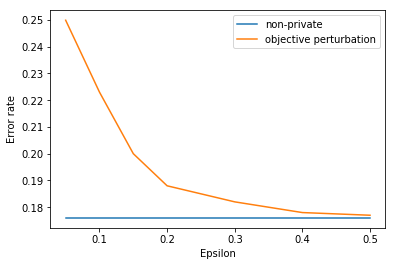

In [444]:
plt.plot(eps, [baseline_err]*len(eps), label='non-private')
plt.plot(eps, err_obj_pert, label='objective perturbation')
plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.legend()
plt.show()

Note that accuracy increases, with increase in epsilon. This is in line with our observation earlier.

### Comparing output vs objective perturbation

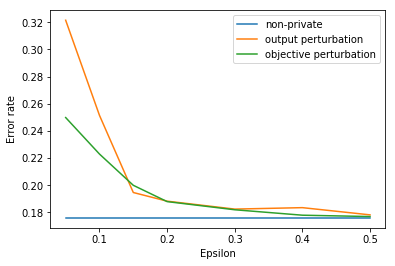

In [450]:
plt.plot(eps, [baseline_err]*len(eps), label='non-private')
plt.plot(eps, lr_op, label='output perturbation')
plt.plot(eps, err_obj_pert, label='objective perturbation')
plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.legend()
plt.show()

For a given privacy parameter $\varepsilon$ it is quite evident that objective perturbation performs better than output perturbation. This is in line with the result published by Chaudhuri et al.

In [392]:
eps = 0.1
np_err = []
priv_op_err = []
priv_obj_err = []
for each in datasets:
    x_tr, y_tr, x_test, y_test = each 
    priv, n_priv = lr_output_perturbation_train(x_tr,y_tr, eps)
    priv_o = lr_objective_train( x_tr, y_tr, eps)
    np_err.append(error_rate_compute(x_test,y_test,n_priv ))
    priv_op_err.append(error_rate_compute(x_test,y_test,priv ))
    priv_obj_err.append(error_rate_compute(x_test,y_test,priv_o ))

### Num training samples vs accuracy for a given privacy setting $\varepsilon = 0.1$

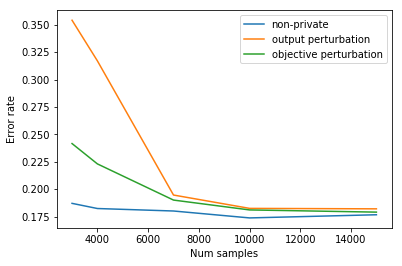

In [425]:
plt.plot(sz, np_err, label='non-private')
plt.plot(sz, priv_op_err, label='output perturbation')
plt.plot(sz, priv_obj_err,label = 'objective perturbation')
plt.xlabel('Num samples')
plt.ylabel('Error rate')
plt.legend()
plt.show()

# Conclusions and Future work
It is seen that for a given privacy setting, objective perturbation performs better than output perturbation. We also see from the chart above that for a given $\varepsilon$, accuracy increases when the number of training samples increases. <br>
Carry out similar analysis for techniques based on input perturbations and other mechanisms such as gaussian processes.

# References
1) Kamalika Chaudhuri, Claire Monteleoni, Anand D.Sarwate - Differentially Private Emperical Risk Minimization http://www.jmlr.org/papers/volume12/chaudhuri11a/chaudhuri11a.pdf

2) Cynthia Dworok, Aaron Roth - The algorithmic foundations of Differential Privacy - https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf

3) Matt Fredrikson, Somesh Jha, Thomas Ristenpart - Model Inversion Attacks that Exploit Confidence Information and Basic Countermeasures - https://www.cs.cmu.edu/~mfredrik/papers/fjr2015ccs.pdf